In [319]:
# PYTHON IMPORTS
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
from random import randint

# LANDLAB COMPONENTS 
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.components import PrecipitationDistribution

# SPACE COMPONENTS 
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

# LANDLAB UTILITIES 
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 
from landlab.utils.flow__distance import calculate_flow__distance

%matplotlib inline

retrieving the topography from ascii

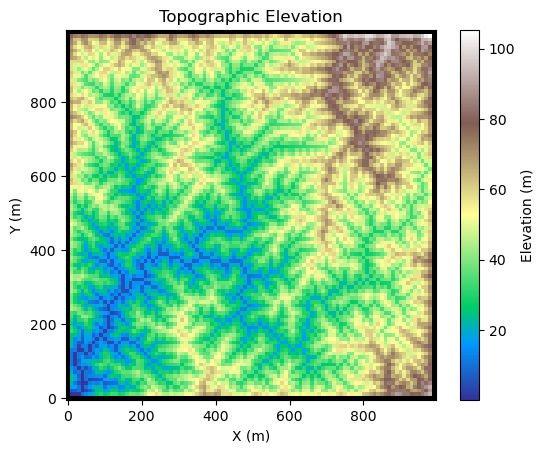

In [320]:
# GRID SPECS
ncols = 100
nrows = 100
cellsize = 10

# RETRIEVE TOPO FROM ASCII
#path_project = r"C:/Users/gsbir/Documents/EES_393/Export/" # add the path to the asc file    #this should access my H drive
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
topo_path = topo_dem
topo_header = read_asc_header(open(topo_path, 'r'))
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0) #generating the new grid

# FIND OUTLET
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()
min_topo_ID = open_nodes[min_topo]
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
outlet_id = min_topo_ID

# HYDROLOGICALLY FILL THE DEM
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

# CLOSE BOUNDARIES
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)

# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [321]:
# PARAMETERS FOR SPACE
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

# ADDING SOIL FIELD
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

# ADDING BEDROCK FIELD
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']

# SETTING UP OUTLET ID 
mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)

# ADDING SURFACE WATER DEPTH
mg.add_zeros('surface_water__depth', at='node')

## Setting initial fields...
mg["node"]["surface_water__discharge"] = np.zeros(mg.number_of_nodes)

#INSTANTIATING COMPONENTS 
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

fa = FlowAccumulator(mg, flow_director='D8') 

df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 

expweath = ExponentialWeatherer(mg)
DDdiff = DepthDependentDiffuser(mg, .0001)
expweath.calc_soil_prod_rate()
np.allclose(mg.at_node['soil_production__rate'][mg.core_nodes], .0001)

#RUNNING FSC FOR 1 YEAR TO IDENTIFY CHANNELS 
fa.run_one_step()
df.map_depressions()
fsc.run_one_step(1)

# SET UP CHANNEL PROFILER AND RUN 
profiler = ChannelProfiler(mg,number_of_watersheds=1,minimum_channel_threshold=0,main_channel_only=True)
profiler.run_one_step()
profiler.data_structure.keys() #is [101]
profiler.data_structure[101].keys()
profiler.data_structure[101][(101,9687)]["ids"] #produces array of id values for the channel

101


array([ 101,  102,  103,  204,  304,  404,  504,  604,  704,  803,  902,
       1002, 1102, 1202, 1303, 1304, 1205, 1306, 1406, 1507, 1608, 1709,
       1810, 1911, 2011, 2111, 2211, 2312, 2411, 2511, 2612, 2713, 2814,
       2915, 2916, 3017, 3117, 3218, 3219, 3220, 3321, 3421, 3520, 3620,
       3721, 3822, 3723, 3824, 3925, 3926, 3927, 3828, 3829, 3830, 3731,
       3632, 3633, 3734, 3735, 3836, 3837, 3838, 3739, 3740, 3741, 3642,
       3643, 3744, 3745, 3746, 3647, 3548, 3448, 3349, 3249, 3149, 3048,
       2947, 2846, 2747, 2648, 2549, 2448, 2447, 2346, 2247, 2147, 2048,
       1949, 1950, 1951, 2052, 1953, 1954, 1855, 1756, 1657, 1558, 1559,
       1460, 1361, 1462, 1563, 1664, 1764, 1864, 1965, 2065, 2165, 2266,
       2366, 2465, 2565, 2665, 2766, 2767, 2768, 2669, 2770, 2871, 2972,
       2973, 3074, 3175, 3076, 3077, 3178, 3279, 3180, 3281, 3382, 3481,
       3581, 3681, 3781, 3880, 3981, 4081, 4180, 4281, 4381, 4482, 4583,
       4584, 4585, 4686, 4687, 4588, 4589, 4690, 47

In [322]:
# VARIABLES FOR OVERLAND FLOW AND PRECIP

## OVERALL
rain_total_t =15 #8760 *1#(hrs) 3make this for spring season actually 
model_total_t = 8760*1 #(hrs)
## SPRING
spring_stm_avg_dur = 1
spring_interstm_avg_dur = 5
spring_stm_avg_int = 50



In [323]:
# INITIALIZE RAIN COMPONENTS 
of = OverlandFlow(mg, steep_slopes=True)
rain = PrecipitationDistribution(mg,mean_storm_duration=spring_stm_avg_dur, mean_interstorm_duration=spring_interstm_avg_dur,mean_storm_depth=spring_stm_avg_int, total_t=rain_total_t, delta_t=1.0)

storm_time_data = []
interstorm_time_data = []
storm_amt_data = []
hydrograph_time = []

## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []

outlet_node_to_sample = 404
outlet_link_to_sample = mg.links_at_node[outlet_node_to_sample][3]
upstream_node_to_sample = 1102
upstream_link_to_sample = mg.links_at_node[upstream_node_to_sample][3]
midstream_node_to_sample = 1709
midstream_link_to_sample = mg.links_at_node[midstream_node_to_sample][3]

#depth, overland flow, SPACE


#test of precip
precip = PrecipitationDistribution(mg, mean_storm_duration=8.5,
    mean_interstorm_duration=19.0, mean_storm_depth=3,
    total_t=46)
storm_dts = []
interstorm_dts = []
intensities = []
precip.seed_generator(seedval=1)
for (storm_dt, interstorm_dt) in precip.yield_storms():
    storm_dts.append(storm_dt)
    interstorm_dts.append(interstorm_dt)
    intensities.append(mg.at_grid['rainfall__flux'])
    plt.figure()# plot up this storm
    imshow_grid(mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (mm/h)')
    plt.show()
len(storm_dts) == 4  # 4 storms in the simulation

In [324]:
# RUN OVERLAND FLOW AND RAIN TOGETHER
stm_dur=[]
interstm_dur=[]
num_stm = 0
int_pattern=[]
first_int_pattern = []
## GET STORM INFO FIRST
first = False
second = False
rain.seed_generator(seedval=1)
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    
    for x in range(int(storm_t)):
        int_pattern.append(mg.at_grid['rainfall__flux']) #add intensity for duration of the storm
        if(first):
             first_int_pattern.append(mg.at_grid['rainfall__flux']) #add intensity for duration of the storm
             #first =False
        
    for x in range(int(interstorm_t)):
        int_pattern.append(0) #no intensity during interstorm period
        if(second):
             first_int_pattern.append(mg.at_grid['rainfall__flux']) #add intensity for duration of the storm
             #second=False

    stm_dur.append(storm_t)
    interstm_dur.append(interstorm_t)
    num_stm+=1
    storm_amt_data.append(num_stm)

print("Number of storms from iterator= "+ str(num_stm))

print(len(int_pattern))

model_elapsed_time = 0 #for loop interation
first_stm = len(first_int_pattern)
print(first_stm)
model_time = 0
#first get array of storm time 
add_time = 200
for x in range(add_time):
    int_pattern.append(0)
while model_elapsed_time <= len(int_pattern):
    #now run overland flow for each hour
    if model_elapsed_time < len(int_pattern):
        #then make a hydrograph
        
        of.dt = 1
        of.rainfall_intensity = int_pattern[model_elapsed_time]
        of.run_one_step()
        hydrograph_time.append(model_elapsed_time)
        q = mg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * mg.dx)
        discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * mg.dx)
        discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * mg.dx)
        #print(np.abs(q[outlet_link_to_sample]) * mg.dx)
        
        model_elapsed_time+=1
        print(model_elapsed_time)
    else:
        break


    

    
    


Number of storms from iterator= 3
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212


# RUN OVERLAND FLOW AND RAIN TOGETHER

i = 0 #for loop interation
#while(i < rain_total_t):
    # 1 season = 90 days = 2160 hrs = 7776000 s
    
    #run one season at a time for final
    
    #this is running for a year
rain.seed_generator(seedval=0)

for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    of.dt = storm_t
    of.rainfall_intensity = spring_stm_avg_int
    storm_time_data.append(storm_t)
    interstorm_time_data.append(interstorm_t)#*.041)
    storm_amt_data.append(i)
    #mg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    #mg.at_node['rainfall__flux'] *= 2.0  # to make the storm heavier
   # print(rain.median_total_rainfall_this_year)
    #print(rain.total_time)
    #plt.figure()# plot up this storm
    #imshow_grid(mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (mm/h)')
    #plt.show()
    
    mg.at_node['bedrock__elevation'][mg.core_nodes] += .00001  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][mg.core_nodes]+= .00001  #adding uplift to the bedrock
    #mg.at_node["topographic__elevation"][outlet_id] -= 0.001 # Uplift
    
    ## Append time and discharge to their lists to save data and for plotting.
    
    hydrograph_time.append(i)
    q = mg.at_link["surface_water__discharge"]
    discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * mg.dx)
    discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * mg.dx)
    discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * mg.dx)
    print(np.abs(q[outlet_link_to_sample]) * mg.dx)
    i+=1
        
    
    
    #fr.run_one_step()
    #sp.run_one_step(dt = (1/rain_total_t))
    
    
    
    i+=1 #iterate 



[  1.00000000e-05   1.00000000e-05   1.00000000e-05 ...,   1.00000000e-05
   1.00000000e-05   1.00000000e-05]


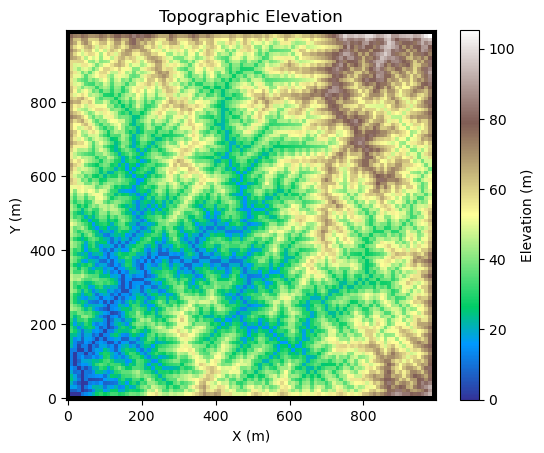

In [325]:
print(mg.at_node['surface_water__depth'])

# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

[]


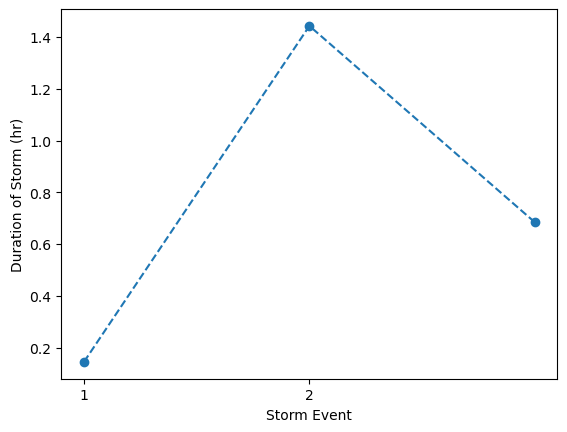

In [326]:
#show graphs of storm time and interstorm data
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
plot.plot(storm_amt_data, stm_dur,linestyle='--', marker='o')
plt.xlabel("Storm Event")
plt.ylabel("Duration of Storm (hr)")
plt.xticks(np.arange(1,num_stm,1))
print(storm_time_data)
total_t_check = sum(storm_time_data)

[]
0


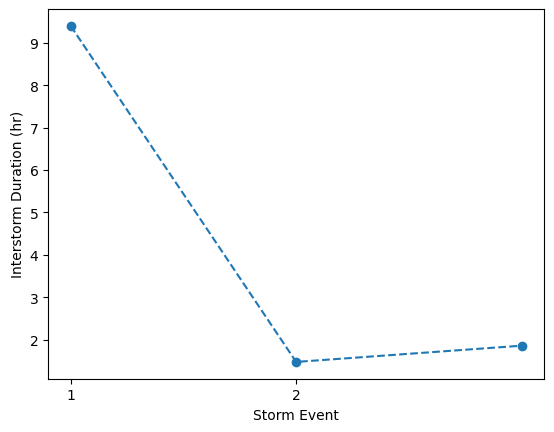

In [327]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
plot.plot(storm_amt_data, interstm_dur,linestyle='--', marker='o')
plt.xlabel("Storm Event")
plt.ylabel("Interstorm Duration (hr)")
plt.xticks(np.arange(1,num_stm,1))
print(interstorm_time_data)
total_t_check += sum(interstorm_time_data)
print(total_t_check)

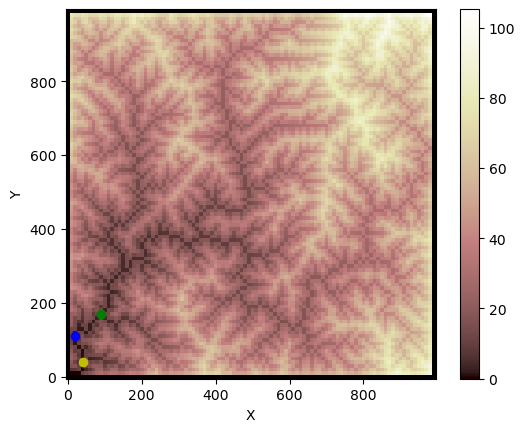

In [328]:
plt.figure(1)
imshow_grid(mg, z)  # plot the DEM
plt.plot(mg.node_x[outlet_node_to_sample], mg.node_y[outlet_node_to_sample], "yo")
plt.plot(mg.node_x[upstream_node_to_sample], mg.node_y[upstream_node_to_sample], "bo")
plt.plot(
    mg.node_x[midstream_node_to_sample], mg.node_y[midstream_node_to_sample], "go"
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Hydrographs')

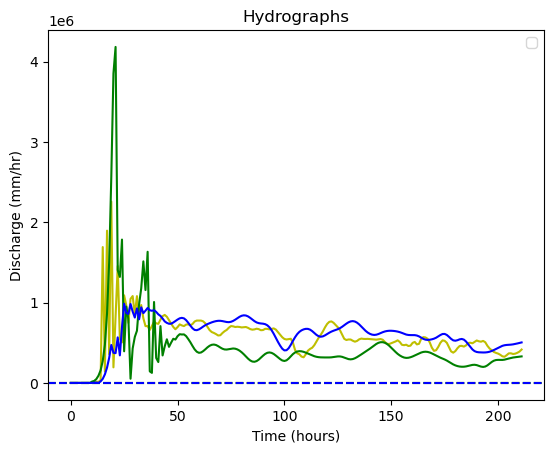

In [329]:
## Code Block 7
avg_int_for_dis = int_pattern[1]#sum(int_pattern)/len(int_pattern) mm/hr

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = (avg_int_for_dis* mg.at_node["drainage_area"][outlet_node_to_sample])
midstream_eq_q = (avg_int_for_dis* mg.at_node["drainage_area"][midstream_node_to_sample])
upstream_eq_q = (avg_int_for_dis * mg.at_node["drainage_area"][upstream_node_to_sample])

plt.figure(1)

## PLOT EQUILIBRIUM DISCHARGE LINES
plt.axhline(y=outlet_eq_q, color='y', linestyle='--')
plt.axhline(y=midstream_eq_q, color='g', linestyle='--')
plt.axhline(y=upstream_eq_q, color='b', linestyle='--')

## NOW PLOT HYDROGRAPH LINES
plt.plot(hydrograph_time, discharge_at_outlet,"y-")
plt.plot(hydrograph_time, discharge_midstream,"g-")
plt.plot(hydrograph_time, discharge_upstream,"b-")

## Plot storm end and center of storm for reference
#plt.plot([spring_stm_avg_dur, spring_stm_avg_dur], [0, 100], "k-", linewidth=2, label="storm end")
#plt.plot([spring_stm_avg_dur / 2, spring_stm_avg_dur / 2], [0, 100], "k:", label="storm mid point")

plt.ylabel("Discharge (mm/hr)")
plt.xlabel("Time (hours)")
plt.legend(loc="upper right")
title_text = "Hydrographs" 
plt.title(title_text)
#plt.axis([0, np.max(hydrograph_time), 0, np.max(hydrograph_time)])
#print(discharge_at_outlet)
#print(discharge_midstream)
#print(discharge_upstream)

plt.figure(1)
## NOW PLOT HYDROGRAPH LINES
plt.plot(hydrograph_time, discharge_at_outlet,"y-", label="outlet")
plt.plot(hydrograph_time, discharge_midstream,"b-", label="midstream")
plt.plot(hydrograph_time, discharge_upstream,"g-" ,label="upstream")